In [1]:
import xarray
import s3fs

In [2]:
s3 = s3fs.S3FileSystem(anon=True)
def lookup(path): 
        return s3fs.S3Map(path, s3=s3) 

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


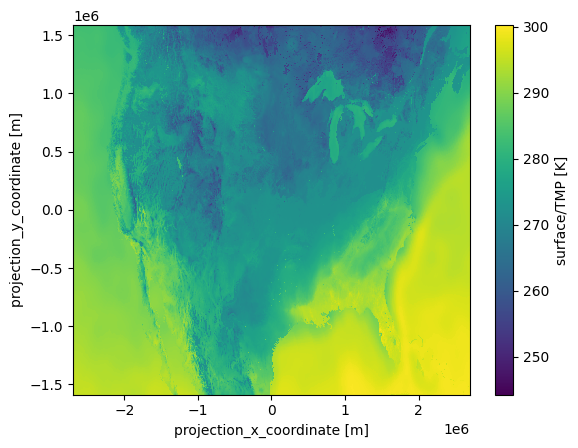

In [3]:
path = "hrrrzarr/sfc/20230101/20230101_00z_anl.zarr/surface/TMP" 
ds = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr") 
ds.TMP.plot()